In [1]:
%matplotlib inline

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
"""
Data Management
"""
data = pd.read_csv("tree_addhealth.csv")

#upper-case all DataFrame column names
data.columns = map(str.upper, data.columns)

# Data Management

data_clean = data.dropna()

# subset clustering variables
cluster=data_clean[['ALCEVR1','MAREVER1','ALCPROBS1','DEVIANT1','VIOL1',
'DEP1','ESTEEM1','SCHCONN1','PARACTV', 'PARPRES','FAMCONCT']]

cluster.describe().T

,count,mean,std,min,25%,50%,75%,max
ALCEVR1,4575.0,0.527432,0.499302,0.0,0.0,1.0,1.0,1.0
MAREVER1,4575.0,0.241967,0.428321,0.0,0.0,0.0,0.0,1.0
ALCPROBS1,4575.0,0.369180,0.894947,0.0,0.0,0.0,0.0,6.0
DEVIANT1,4575.0,2.645027,3.520554,0.0,0.0,1.0,4.0,27.0
VIOL1,4575.0,1.618579,2.593230,0.0,0.0,0.0,2.0,19.0
DEP1,4575.0,8.537049,6.571052,0.0,4.0,7.0,12.0,48.0
ESTEEM1,4575.0,40.952131,5.381439,18.0,38.0,40.0,45.0,50.0
SCHCONN1,4575.0,28.360656,5.156385,6.0,25.0,29.0,32.0,38.0
PARACTV,4575.0,6.290710,3.360219,0.0,4.0,6.0,9.0,18.0
PARPRES,4575.0,13.398033,2.085837,3.0,12.0,14.0,15.0,15.0


In [7]:
{(cluster['PARACTV'])}

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [3]:
# standardize clustering variables to have mean=0 and sd=1
clustervar=cluster.copy()
clustervar['ALCEVR1']=preprocessing.scale(clustervar['ALCEVR1'].astype('float64'))
clustervar['ALCPROBS1']=preprocessing.scale(clustervar['ALCPROBS1'].astype('float64'))
clustervar['MAREVER1']=preprocessing.scale(clustervar['MAREVER1'].astype('float64'))
clustervar['DEP1']=preprocessing.scale(clustervar['DEP1'].astype('float64'))
clustervar['ESTEEM1']=preprocessing.scale(clustervar['ESTEEM1'].astype('float64'))
clustervar['VIOL1']=preprocessing.scale(clustervar['VIOL1'].astype('float64'))
clustervar['DEVIANT1']=preprocessing.scale(clustervar['DEVIANT1'].astype('float64'))
clustervar['FAMCONCT']=preprocessing.scale(clustervar['FAMCONCT'].astype('float64'))
clustervar['SCHCONN1']=preprocessing.scale(clustervar['SCHCONN1'].astype('float64'))
clustervar['PARACTV']=preprocessing.scale(clustervar['PARACTV'].astype('float64'))
clustervar['PARPRES']=preprocessing.scale(clustervar['PARPRES'].astype('float64'))

In [4]:
# split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

In [5]:
# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

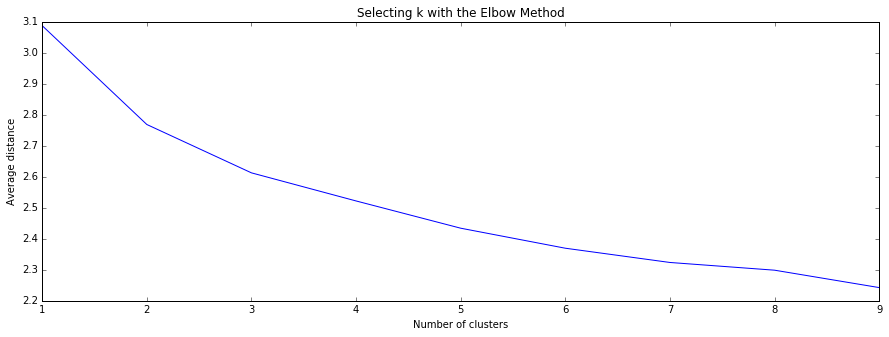

In [6]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

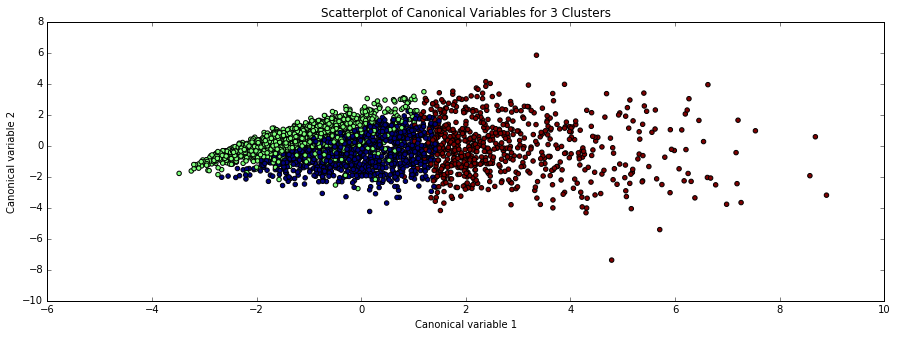

In [7]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

# plot clusters
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [8]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)

# create a list that has the new index variable
cluslist=list(clus_train['index'])

# create a list of cluster assignments
labels=list(model3.labels_)

# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
#print(newlist)

# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
#print(newclus)

# rename the cluster assignment column
newclus.columns = ['cluster']

In [9]:
# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)

# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)

# cluster frequencies
merged_train.cluster.value_counts()

1    1420
0    1108
2     674
Name: cluster, dtype: int64

In [10]:
"""
END multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""

# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index   ALCEVR1  MAREVER1  ALCPROBS1  DEVIANT1     VIOL1  \
cluster                                                                   
0        3328.930505  0.946562 -0.057109  -0.058550 -0.121192 -0.168252   
1        3239.829577 -1.056455 -0.474543  -0.412562 -0.451110 -0.264092   
2        3312.255193  0.661266  1.097891   0.900592  1.106490  0.791967   

             DEP1   ESTEEM1  SCHCONN1   PARACTV   PARPRES  FAMCONCT  
cluster                                                              
0       -0.196987  0.188367  0.131356  0.151205  0.099521  0.226842  
1       -0.292352  0.206912  0.341590  0.091216  0.156604  0.298288  
2        0.853587 -0.655070 -0.927499 -0.409328 -0.473980 -0.955398  


In [11]:
# validate clusters in training data by examining cluster differences in GPA using ANOVA

# first have to merge GPA with clustering variables and cluster assignment data 
gpa_data=data_clean['GPA1']

# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['GPA1', 'cluster']].dropna()

In [12]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

gpamod = smf.ols(formula='GPA1 ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                   GPA1   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     133.3
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           2.50e-56
Time:                        21:38:58   Log-Likelihood:                -3599.3
No. Observations:                3202   AIC:                             7205.
Df Residuals:                    3199   BIC:                             7223.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           2.8299      0.022    1

In [13]:
print ('Means for GPA by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

Means for GPA by cluster
             GPA1
cluster          
0        2.829949
1        2.994542
2        2.426063


In [14]:
print ('Standard deviations for GPA by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

Standard deviations for GPA by cluster
             GPA1
cluster          
0        0.727230
1        0.738174
2        0.786903


In [15]:
mc1 = multi.MultiComparison(sub1['GPA1'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     0.1646   0.0946  0.2346  True 
  0      2    -0.4039  -0.4892 -0.3186  True 
  1      2    -0.5685  -0.6502 -0.4868  True 
---------------------------------------------
